In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

2025-04-10 09:59:27.752112: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744279167.937439      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744279167.992234      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [15]:
del model

In [2]:
! pip install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 3.2 MB/s eta 0:00:00


In [16]:
data = pd.read_csv('/kaggle/input/eurusd60/EURUSD-60-DS.csv')
data.head()

,Date,Open,High,Low,Close,Volume
0,01.01.2008 02:00:00.000,1.45841,1.45982,1.45768,1.45785,12957.8500
1,01.01.2008 03:00:00.000,1.45788,1.45803,1.45754,1.45770,8374.1500
2,01.01.2008 04:00:00.000,1.45770,1.45987,1.45766,1.45913,11715.2595
3,01.01.2008 05:00:00.000,1.45916,1.45946,1.45854,1.45893,20694.8375
4,01.01.2008 06:00:00.000,1.45973,1.45984,1.45892,1.45962,26844.9970


In [17]:
input_features = ['Open', 'High', 'Low', 'Close']
scalers_inputs = {col: MinMaxScaler() for col in input_features}
scaled_inputs = np.array([scalers_inputs[col].fit_transform(data[col].values.reshape(-1, 1)) for col in input_features])
scaled_inputs = np.transpose(scaled_inputs, (1, 0, 2))

# 3. انتخاب تارگت (OHLC)
output_features = ['Open', 'High', 'Low', 'Close']
scalers_outputs = {col: MinMaxScaler() for col in output_features}
scaled_outputs = np.array([scalers_outputs[col].fit_transform(data[col].values.reshape(-1, 1)) for col in output_features])
scaled_outputs = np.transpose(scaled_outputs, (1, 0, 2))

In [18]:
def create_sequences(inputs, outputs, seq_length):
    X, y = [], []
    for i in range(len(inputs) - seq_length):
        X.append(inputs[i:i + seq_length])
        y.append(outputs[i + seq_length])  # 4 مقدار OHLC تایم‌فریم بعدی
    return np.array(X), np.array(y)

seq_length = 1
X, y = create_sequences(scaled_inputs, scaled_outputs, seq_length)

In [19]:
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1)
X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

print("تعداد نمونه‌های Train:", len(X_train))
print("تعداد نمونه‌های Validation:", len(X_val))
print("تعداد نمونه‌های Test:", len(X_test))

تعداد نمونه‌های Train: 84772
تعداد نمونه‌های Validation: 10596
تعداد نمونه‌های Test: 10598


In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Lambda
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

# تعریف تابع ضرر FLF به صورت مستقل
def FLF(yTrue, yPred):
    lam = 0.1
    v = Lambda(lambda x: x * 0.9)((yTrue - yPred))
    vn = Lambda(lambda x: x * lam)(K.abs((yTrue[:, 1] + yTrue[:, 2]) / 2 - (yPred[:, 1] + yPred[:, 2]) / 2))
    vn1 = Lambda(lambda x: x * lam)(K.abs((yTrue[:, 0] + yTrue[:, 3]) / 2 - (yPred[:, 0] + yPred[:, 3]) / 2))
    vx = K.square((v[:, 0] - vn1))
    vy = K.square((v[:, 1] - vn))
    vz = K.square((v[:, 2] - vn))
    v4 = K.square((v[:, 3] - vn1))
    vm = K.concatenate([vx, vy, vz, v4])
    vmx = K.mean(vm)
    return vmx

# ایجاد مدل LSTM بهینه‌شده
model = Sequential([
    LSTM(200,  input_shape=(1, len(input_features))),  # افزایش Sequence Length
    Dropout(0.1),  # افزایش Dropout
    Dense(25, activation='relu'),  # اضافه کردن Dense با ReLU
    Dense(4)  # خروجی یک مقدار عددی
])

optimizer = Adam(learning_rate=0.01)

model.compile(optimizer=optimizer, loss=FLF, metrics=['mae','mse','mape'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 200)                 │         164,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 25)                  │           5,025 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             104 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 169,129 (660.66 KB)

 Trainable params: 169,129 (660.66 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# history = model.fit(X_train, y_train, epochs=50, batch_size=32,
#                     validation_data=(X_val, y_val), callbacks=[early_stop])
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# تعریف EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',           # معیار مانیتورینگ
    patience=10,                  # تعداد epochهایی که صبر می‌کنه
    restore_best_weights=False,   # وزن‌ها به بهترین حالت برنمی‌گردن
    start_from_epoch=10,          # از epoch دهم شروع به چک کردن می‌کنه
    verbose=1                     # گزارش رو چاپ می‌کنه
)

# تعریف ReduceLROnPlateau برای تنظیم نرخ یادگیری
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',           # معیار مانیتورینگ
    factor=0.25,                  # ضریب کاهش نرخ یادگیری
    patience=5,                   # تعداد epochهایی که صبر می‌کنه
    min_lr=1e-6,                  # حداقل نرخ یادگیری
    verbose=1                     # گزارش تغییرات رو چاپ می‌کنه
)

# آموزش مدل با همه callbackها
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/100
2650/2650 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.0029 - mae: 0.0206 - mape: 4.6756 - mse: 0.0043 - val_loss: 8.8228e-05 - val_mae: 0.0094 - val_mape: 2353.2026 - val_mse: 1.1820e-04 - learning_rate: 0.0100
Epoch 2/100
2650/2650 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 6.6976e-05 - mae: 0.0068 - mape: 1.6227 - mse: 8.7520e-05 - val_loss: 1.1729e-05 - val_mae: 0.0023 - val_mape: 1061.0378 - val_mse: 1.2450e-05 - learning_rate: 0.0100
Epoch 3/100
2650/2650 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 4.7223e-05 - mae: 0.0058 - mape: 1.4259 - mse: 6.1539e-05 - val_loss: 1.3229e-05 - val_mae: 0.0039 - val_mape: 391.9191 - val_mse: 2.0199e-05 - learning_rate: 0.0100
Epoch 4/100
2650/2650 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 4.3882e-05 - mae: 0.0056 - mape: 1.4211 - mse: 5.7070e-05 - val_loss: 5.3391e-05 - val_mae: 0.0087 - val_mape: 976.7146 - val_mse: 8.3052e-05 - learning_rate: 0.0100
Epoch 5/100
2650/2650 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 4.1174e-05 - mae: 0.00

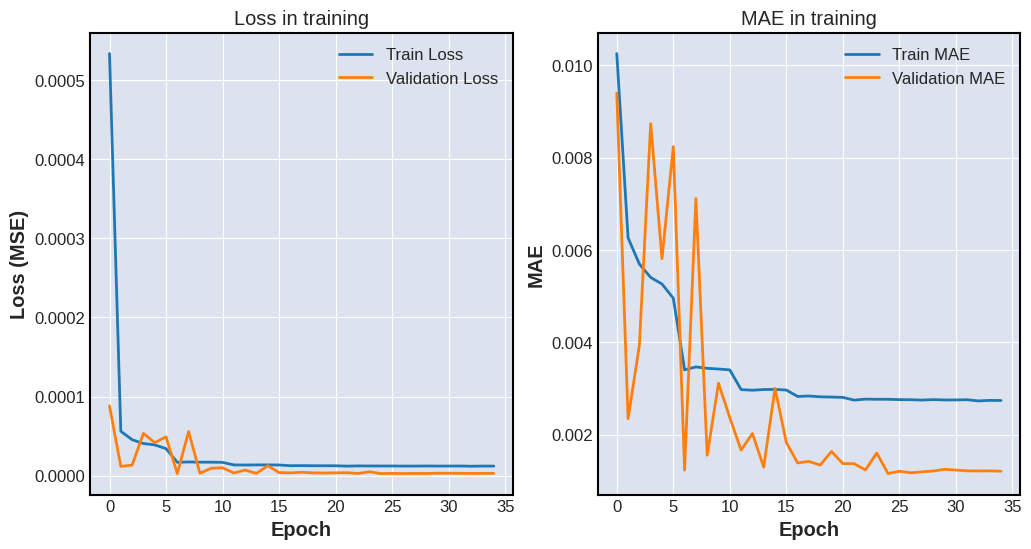

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss in training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE in training')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

332/332 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

معیارهای ارزیابی برای Open:
MSE: 1.7053787548659426e-07
RMSE: 0.00041296231727192044
MAE: 0.0002874745837857895
R² Score: 0.9993953695252972

معیارهای ارزیابی برای High:
MSE: 5.720558158444705e-07
RMSE: 0.000756343715412821
MAE: 0.0005282511513798755
R² Score: 0.9979664428926653

معیارهای ارزیابی برای Low:
MSE: 7.36217416067418e-07
RMSE: 0.0008580311276797702
MAE: 0.0006432576693181939
R² Score: 0.9973958224799857

معیارهای ارزیابی برای Close:
MSE: 9.575954273189024e-07
RMSE: 0.0009785680494063264
MAE: 0.000644822318038753
R² Score: 0.9966068478120508

دقت جهت برای Close: 48.24950457676701%


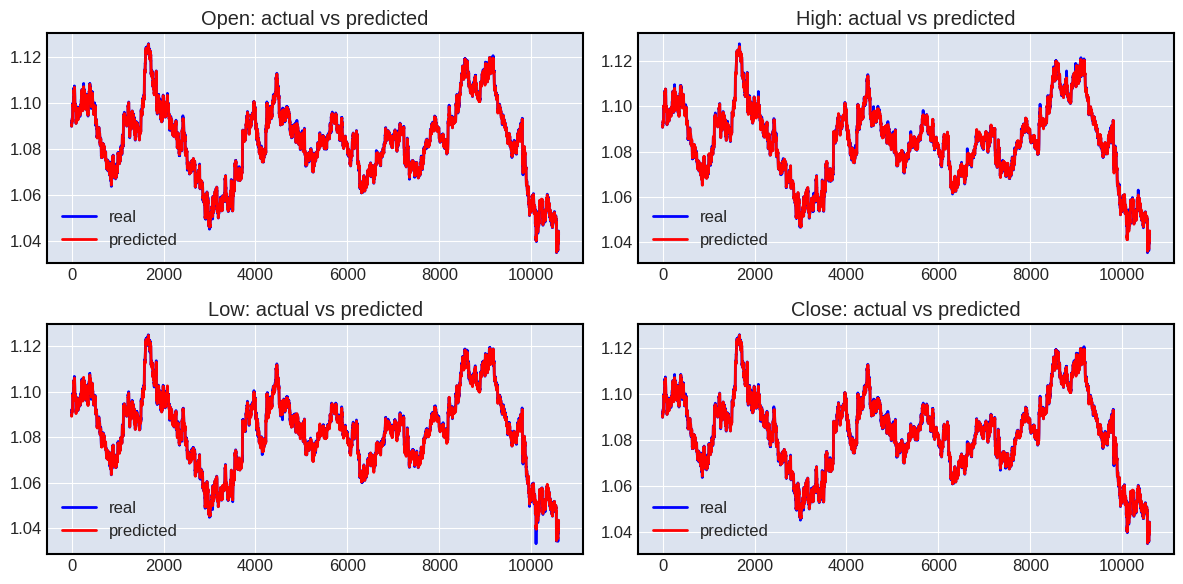

In [24]:
# 9. پیش‌بینی
predictions = model.predict(X_test)

# 10. برگردوندن به مقیاس اصلی
predictions_open = scalers_outputs['Open'].inverse_transform(predictions[:, 0].reshape(-1, 1))
predictions_high = scalers_outputs['High'].inverse_transform(predictions[:, 1].reshape(-1, 1))
predictions_low = scalers_outputs['Low'].inverse_transform(predictions[:, 2].reshape(-1, 1))
predictions_close = scalers_outputs['Close'].inverse_transform(predictions[:, 3].reshape(-1, 1))

y_test_open = scalers_outputs['Open'].inverse_transform(y_test[:, 0].reshape(-1, 1))
y_test_high = scalers_outputs['High'].inverse_transform(y_test[:, 1].reshape(-1, 1))
y_test_low = scalers_outputs['Low'].inverse_transform(y_test[:, 2].reshape(-1, 1))
y_test_close = scalers_outputs['Close'].inverse_transform(y_test[:, 3].reshape(-1, 1))

# 11. محاسبه معیارها برای هر مقدار
def calculate_metrics(y_true, y_pred, name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\nمعیارهای ارزیابی برای {name}:")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R² Score: {r2}")

calculate_metrics(y_test_open, predictions_open, "Open")
calculate_metrics(y_test_high, predictions_high, "High")
calculate_metrics(y_test_low, predictions_low, "Low")
calculate_metrics(y_test_close, predictions_close, "Close")

# 12. دقت جهت برای Close
correct_directions = np.sum(np.sign(predictions_close[1:] - predictions_close[:-1]) == np.sign(y_test_close[1:] - y_test_close[:-1]))
directional_accuracy = correct_directions / (len(predictions_close) - 1)
print(f"\nدقت جهت برای Close: {directional_accuracy * 100}%")

# 13. رسم پیش‌بینی‌ها
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(y_test_open, label='real', color='blue')
plt.plot(predictions_open, label='predicted', color='red')
plt.title('Open: actual vs predicted')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(y_test_high, label='real', color='blue')
plt.plot(predictions_high, label='predicted', color='red')
plt.title('High: actual vs predicted')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(y_test_low, label='real', color='blue')
plt.plot(predictions_low, label='predicted', color='red')
plt.title('Low: actual vs predicted')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(y_test_close, label='real', color='blue')
plt.plot(predictions_close, label='predicted', color='red')
plt.title('Close: actual vs predicted')
plt.legend()

plt.tight_layout()
plt.show()

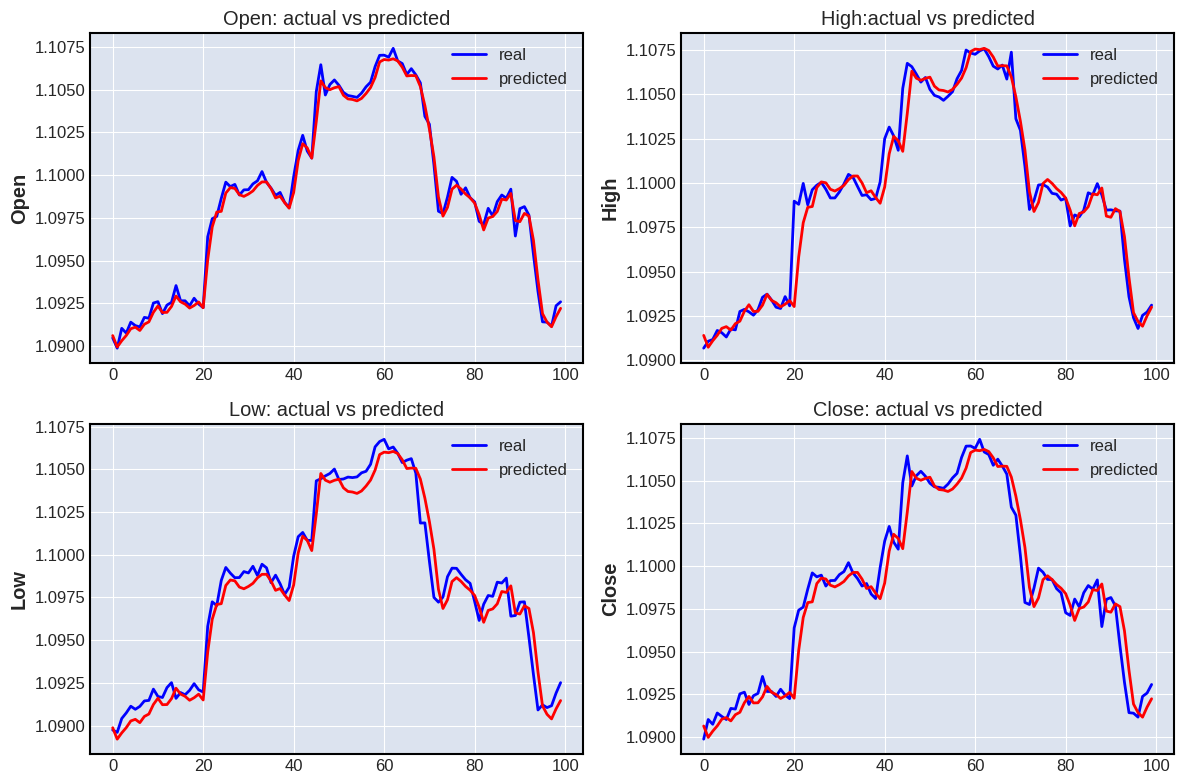

In [25]:
n_samples = 100  # تعداد نمونه‌هایی که می‌خوای نشون بدی

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(y_test_open[:n_samples], label='real', color='blue')
plt.plot(predictions_open[:n_samples], label='predicted', color='red')
plt.title('Open: actual vs predicted')
plt.ylabel('Open')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(y_test_high[:n_samples], label='real', color='blue')
plt.plot(predictions_high[:n_samples], label='predicted', color='red')
plt.title('High:actual vs predicted')
plt.ylabel('High')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(y_test_low[:n_samples], label='real', color='blue')
plt.plot(predictions_low[:n_samples], label='predicted', color='red')
plt.title('Low: actual vs predicted')
plt.ylabel('Low')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(y_test_close[:n_samples], label='real', color='blue')
plt.plot(predictions_close[:n_samples], label='predicted', color='red')
plt.title('Close: actual vs predicted')
plt.ylabel('Close')
plt.legend()

plt.tight_layout()
plt.show()

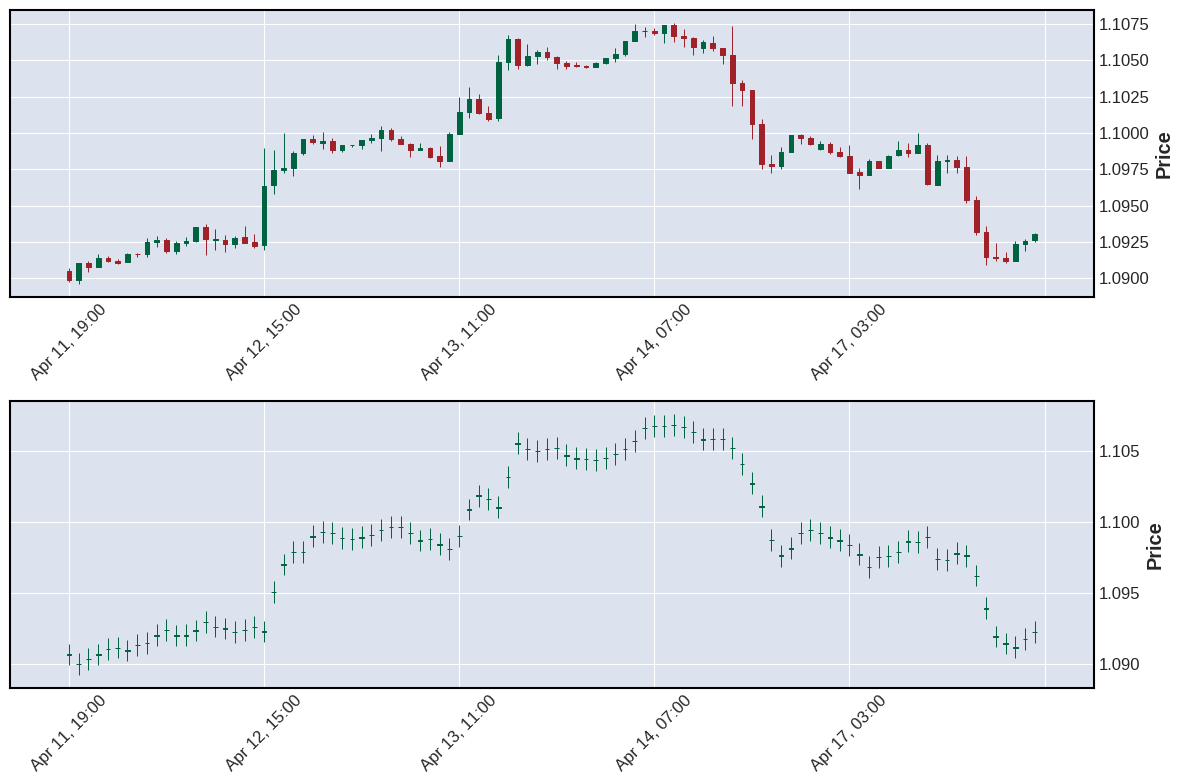

In [26]:
import mplfinance as mpf
data['Date'] = pd.to_datetime(data['Date'], format='mixed', dayfirst=True)
dates = data['Date'].iloc[-len(predictions):].values[:n_samples]
dates = pd.to_datetime(dates)  # تبدیل به datetime

predicted_candles = pd.DataFrame({
    'Date': dates,
    'Open': predictions_open[:n_samples].flatten(),
    'High': predictions_high[:n_samples].flatten(),
    'Low': predictions_low[:n_samples].flatten(),
    'Close': predictions_close[:n_samples].flatten()
})
predicted_candles.set_index('Date', inplace=True)
# مطمئن می‌شیم ایندکس DatetimeIndex باشه
predicted_candles.index = pd.DatetimeIndex(predicted_candles.index)

actual_candles = pd.DataFrame({
    'Date': dates,
    'Open': y_test_open[:n_samples].flatten(),
    'High': y_test_high[:n_samples].flatten(),
    'Low': y_test_low[:n_samples].flatten(),
    'Close': y_test_close[:n_samples].flatten()
})
actual_candles.set_index('Date', inplace=True)
# مطمئن می‌شیم ایندکس DatetimeIndex باشه
actual_candles.index = pd.DatetimeIndex(actual_candles.index)

# رسم کندل‌ها با استفاده از mpf.make_subplots
# به جای plt.subplots، از خود mplfinance برای مدیریت زیرنمودارها استفاده می‌کنیم
fig = mpf.figure(figsize=(12, 8))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2, sharex=ax1)

# رسم کندل‌های واقعی و پیش‌بینی‌شده
mpf.plot(actual_candles, type='candle', style='charles', ax=ax1)
mpf.plot(predicted_candles, type='candle', style='charles', ax=ax2)

# تنظیم فاصله بین زیرنمودارها
fig.tight_layout()
mpf.show()

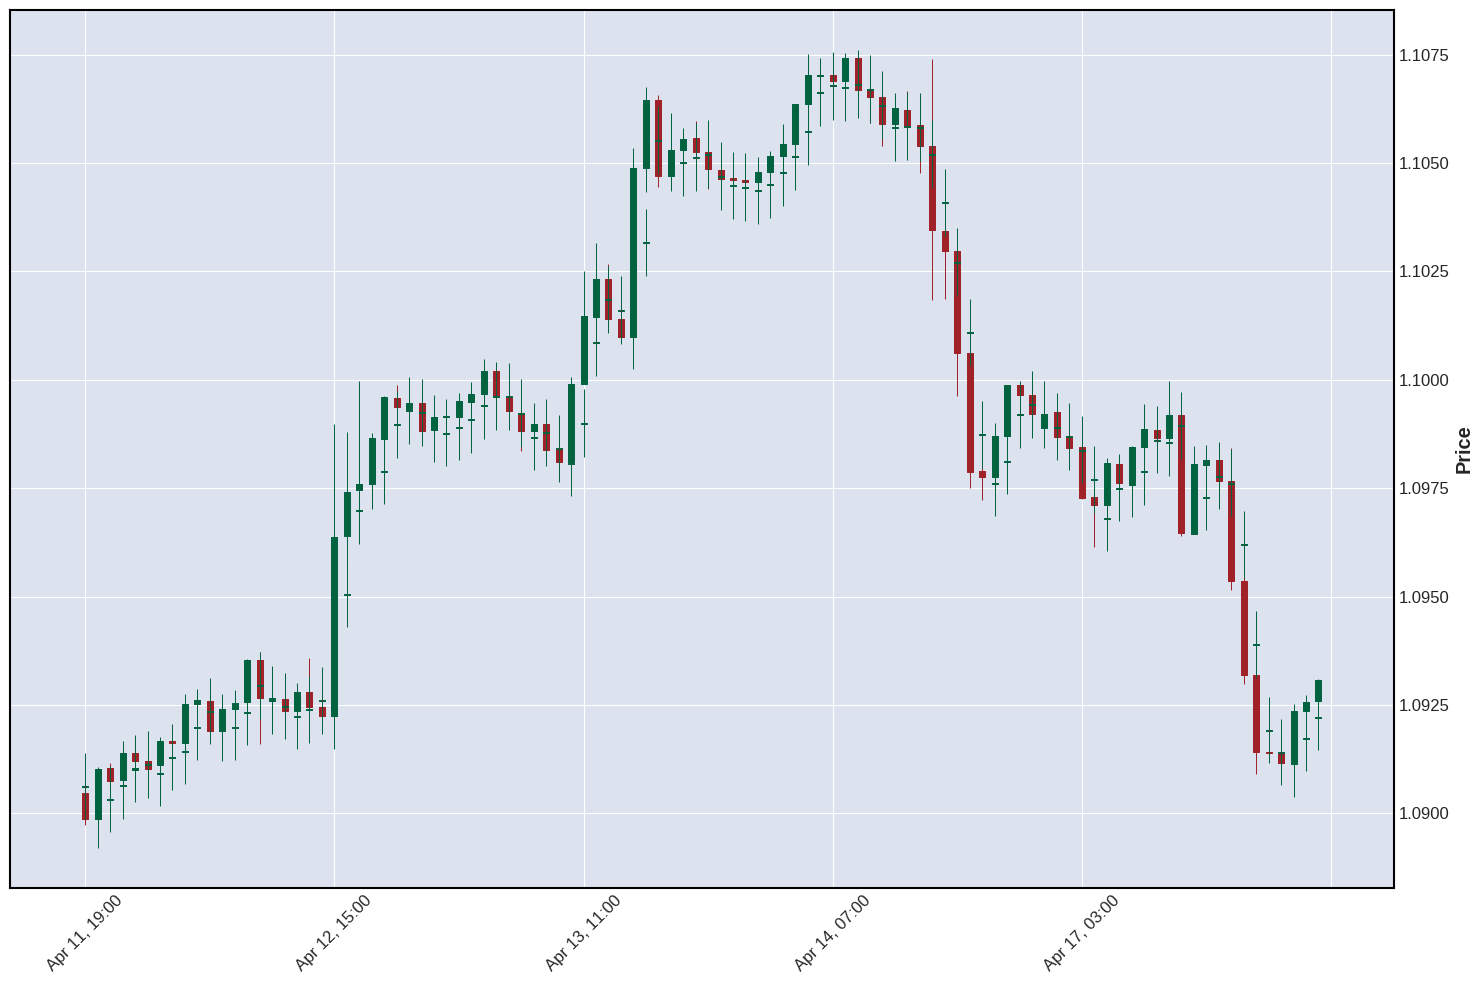

In [27]:
data['Date'] = pd.to_datetime(data['Date'], format='mixed', dayfirst=True)
dates = data['Date'].iloc[-len(predictions):].values[:n_samples]
dates = pd.to_datetime(dates)  # تبدیل به datetime

predicted_candles = pd.DataFrame({
    'Date': dates,
    'Open': predictions_open[:n_samples].flatten(),
    'High': predictions_high[:n_samples].flatten(),
    'Low': predictions_low[:n_samples].flatten(),
    'Close': predictions_close[:n_samples].flatten()
})
predicted_candles.set_index('Date', inplace=True)
# مطمئن می‌شیم ایندکس DatetimeIndex باشه
predicted_candles.index = pd.DatetimeIndex(predicted_candles.index)

actual_candles = pd.DataFrame({
    'Date': dates,
    'Open': y_test_open[:n_samples].flatten(),
    'High': y_test_high[:n_samples].flatten(),
    'Low': y_test_low[:n_samples].flatten(),
    'Close': y_test_close[:n_samples].flatten()
})
actual_candles.set_index('Date', inplace=True)
# مطمئن می‌شیم ایندکس DatetimeIndex باشه
actual_candles.index = pd.DatetimeIndex(actual_candles.index)

fig = mpf.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1)

mpf.plot(actual_candles, type='candle', style='charles', ax=ax)


# کندل‌های پیش‌بینی‌شده (پررنگ) روی همون محور
mpf.plot(predicted_candles, type='candle', style='charles', ax=ax)


# نمایش نمودار
fig.tight_layout()
mpf.show()